# Дисклеймер
Эту тетрадку нужно запускать в колабе или в vast.ai. Не мучатесь с установкой библиотек и с обучением на cpu.

In [1]:
from google.colab import files
uploaded = files.upload()

Saving data (1).zip to data (1).zip


In [3]:
!unzip 'data (1).zip'

Archive:  data (1).zip
  inflating: quora.csv               
  inflating: __MACOSX/._quora.csv    


In [0]:
!pip install pandas scikit-learn matplotlib

## Домашка

Сверточные сети относительно хорошо масшабируются на длинные последовательности. Поэтому их часто применяют к отдельным символам, а не токенам. В домашке вам нужно будет обучить большую сверточную модель на символах (отличаться по сути будет только токенизация).

При обучении используйте колбек для отслеживания лучшей модели. Ориентируйтесь на ф1 меру.

Конкретнее задание такое:
Обучите модель с минимум 15 слоями, где у каждого слоя разные параметры (Dropout, Conv1d и Pooling считаются слоями, остальное нет). Как мимнимум 4 слоя должны быть наложены друг на друга. Должен быть хотя бы один слой каждого типа.

Советы: Начните с небольших сетей и постепенно добавляйте, не пытайтесь сразу собрать все слои. Сделайте размер эмбединга сильно меньше. Попробуйте паддинг поменьше. Символьная модель может обучаться намного дольше. Иногда кернел может крашиться просто так или из-за слишком больших матриц.


Бонусный балл можно получить за изучение влияния предобработки (нужно ли приводить к нижнему регистру, нужно ли выкидывать не алфавитные символы, помогает ли замена цифр на определенный токен).

In [0]:
import tensorflow as tf
import pandas as pd
import numpy as np
from string import punctuation
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline

def char_preprocess(text):
    tokens = list(text.strip(punctuation))
    return tokens

In [0]:
from tensorflow.keras import backend as K
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [0]:
quora = pd.read_csv('quora.csv')

In [0]:
vocab = Counter()

for text in quora.question_text:
    vocab.update(char_preprocess(text))

# отфильтрованный словарь
filtered_vocab = set()

for word in vocab:
    if vocab[word] > 5:
        filtered_vocab.add(word)

word2id = {'UNK':1, 'PAD':0}

for word in filtered_vocab:
    word2id[word] = len(word2id)

id2word = {i:word for word, i in word2id.items()}

X = []

for text in quora.question_text:
    tokens = char_preprocess(text)
    ids = [word2id.get(token, 1) for token in tokens]
    X.append(ids)

In [18]:
for i in range(10,1000,50):
  print(i, len([len(x) for x in X if len(x) <= i]))

10 120
60 678050
110 1137951
160 1260707
210 1290374
260 1306082
310 1306113
360 1306118
410 1306118
460 1306118
510 1306119
560 1306119
610 1306119
660 1306119
710 1306119
760 1306120
810 1306120
860 1306120
910 1306121
960 1306121


In [0]:
MAX_LEN = 110 # при этом значении мы покрывем немнгим меньше чем 90% текстов

X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=MAX_LEN)

In [0]:
y = quora.target.values

In [0]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.05, stratify=y)

In [0]:
# ModelCheckpoint сохраняет лучшие версии моделей
checkpoint = tf.keras.callbacks.ModelCheckpoint('model.weights', # названия файла 
                                                monitor='val_f1', # за какой метрикой следить
                                                verbose=1, # будет печатать что происходит
                                                save_weights_only=True, # если нужно только веса сохранить
                                                save_best_only=True, # сохранять только лучшие
                                                mode='max', # если метрика должна расти, то тут max и min если наоборот
                                                save_freq='epoch' # как часто вызывать
                                               )
                                               

# EarlyStopping позволяет автоматически остановить обучение, если качество не улучшается 
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_f1', 
                                              min_delta=0.01, # какая разница считается как улучшение
                                              patience=5, # сколько эпох терпеть отсутствие улучшений
                                              verbose=1, 
                                              mode='max',
                                              )

In [62]:
 inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=100)(inputs)

mean = tf.keras.layers.Flatten()(embeddings)
dense = tf.keras.layers.Dense(64, activation='relu')(mean)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(dense)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=[f1])
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=4000,
         epochs=20,
         callbacks=[checkpoint, early_stop])

Epoch 1/20
310/311 [============================>.] - ETA: 0s - loss: 0.2092 - f1: 0.0033
Epoch 00001: val_f1 improved from -inf to 0.00000, saving model to model.weights
311/311 [==============================] - 23s 75ms/step - loss: 0.2092 - f1: 0.0033 - val_loss: 0.1972 - val_f1: 0.0000e+00
Epoch 2/20
310/311 [============================>.] - ETA: 0s - loss: 0.1941 - f1: 0.0079
Epoch 00002: val_f1 improved from 0.00000 to 0.01218, saving model to model.weights
311/311 [==============================] - 23s 74ms/step - loss: 0.1941 - f1: 0.0079 - val_loss: 0.1931 - val_f1: 0.0122
Epoch 3/20
310/311 [============================>.] - ETA: 0s - loss: 0.1886 - f1: 0.0398
Epoch 00003: val_f1 improved from 0.01218 to 0.04115, saving model to model.weights
311/311 [==============================] - 23s 74ms/step - loss: 0.1886 - f1: 0.0400 - val_loss: 0.1902 - val_f1: 0.0411
Epoch 4/20
310/311 [============================>.] - ETA: 0s - loss: 0.1835 - f1: 0.0857
Epoch 00004: val_f1 impr

dict_keys(['loss', 'f1', 'val_loss', 'val_f1'])


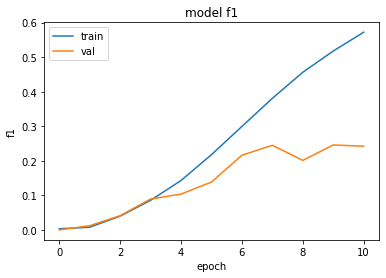

In [63]:
# BASIC

print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['f1'])
plt.plot(model.history.history['val_f1'])
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [64]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=100)(inputs)

conv1 = tf.keras.layers.Conv1D(kernel_size=10, filters=32, kernel_regularizer='l2')(embeddings)

mean = tf.keras.layers.Flatten()(conv1)
dense = tf.keras.layers.Dense(64, activation='relu')(mean)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(dense)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=[f1])

model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=4000,
         epochs=20,
         callbacks=[checkpoint, early_stop])

Epoch 1/20
310/311 [============================>.] - ETA: 0s - loss: 0.2679 - f1: 0.0105
Epoch 00001: val_f1 did not improve from 0.24589
311/311 [==============================] - 29s 92ms/step - loss: 0.2679 - f1: 0.0105 - val_loss: 0.2058 - val_f1: 0.0081
Epoch 2/20
310/311 [============================>.] - ETA: 0s - loss: 0.2028 - f1: 0.0060
Epoch 00002: val_f1 did not improve from 0.24589
311/311 [==============================] - 28s 91ms/step - loss: 0.2028 - f1: 0.0060 - val_loss: 0.1995 - val_f1: 0.0034
Epoch 3/20
310/311 [============================>.] - ETA: 0s - loss: 0.1981 - f1: 0.0197
Epoch 00003: val_f1 did not improve from 0.24589
311/311 [==============================] - 29s 94ms/step - loss: 0.1981 - f1: 0.0197 - val_loss: 0.1952 - val_f1: 0.0184
Epoch 4/20
310/311 [============================>.] - ETA: 0s - loss: 0.1945 - f1: 0.0353
Epoch 00004: val_f1 did not improve from 0.24589
311/311 [==============================] - 29s 92ms/step - loss: 0.1945 - f1: 0.0

dict_keys(['loss', 'f1', 'val_loss', 'val_f1'])


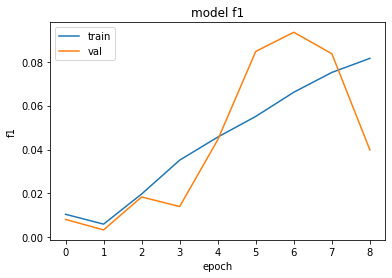

In [65]:
# 1 conv layer

print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['f1'])
plt.plot(model.history.history['val_f1'])
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [66]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=100)(inputs, )
convs = []

for ks in [2,3,4,5]:
    conv1 = tf.keras.layers.Conv1D(kernel_size=ks, filters=32, padding='same',strides=1)(embeddings)
    conv2 = tf.keras.layers.Conv1D(kernel_size=ks, filters=32, padding='same',strides=1, 
                                  kernel_regularizer='l2', activation='relu')(conv1)
    convs.append(conv2)


mean = tf.keras.layers.concatenate(convs, axis=2)

flatten = tf.keras.layers.Flatten()(mean)
dense = tf.keras.layers.Dense(50, activation='relu')(flatten)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(dense)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=[f1])

model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=4000,
         epochs=20,
         callbacks=[checkpoint, early_stop])

Epoch 1/20
310/311 [============================>.] - ETA: 0s - loss: 0.4226 - f1: 3.0606e-04
Epoch 00001: val_f1 did not improve from 0.24589
311/311 [==============================] - 46s 148ms/step - loss: 0.4224 - f1: 3.0507e-04 - val_loss: 0.1826 - val_f1: 0.0000e+00
Epoch 2/20
310/311 [============================>.] - ETA: 0s - loss: 0.1764 - f1: 0.1085
Epoch 00002: val_f1 did not improve from 0.24589
311/311 [==============================] - 46s 148ms/step - loss: 0.1764 - f1: 0.1090 - val_loss: 0.1740 - val_f1: 0.1041
Epoch 3/20
310/311 [============================>.] - ETA: 0s - loss: 0.1681 - f1: 0.2015
Epoch 00003: val_f1 did not improve from 0.24589
311/311 [==============================] - 46s 148ms/step - loss: 0.1681 - f1: 0.2013 - val_loss: 0.1651 - val_f1: 0.1508
Epoch 4/20
310/311 [============================>.] - ETA: 0s - loss: 0.1627 - f1: 0.2540
Epoch 00004: val_f1 improved from 0.24589 to 0.29025, saving model to model.weights
311/311 [======================

dict_keys(['loss', 'f1', 'val_loss', 'val_f1'])


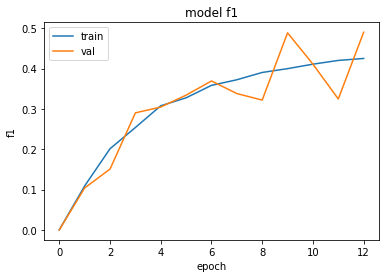

In [67]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['f1'])
plt.plot(model.history.history['val_f1'])
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [68]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=100)(inputs, )
convs = []

for ks in [2,3,4,5]:
    conv1 = tf.keras.layers.Conv1D(kernel_size=ks, filters=32, padding='same',strides=1)(embeddings)
    conv2 = tf.keras.layers.Conv1D(kernel_size=ks, filters=32, padding='same',strides=1, 
                                  kernel_regularizer='l2', activation='relu')(conv1)
    convs.append(conv2)


concat = tf.keras.layers.concatenate(convs, axis=2)

conv_global = tf.keras.layers.Conv1D(kernel_size=5, filters=32, strides=1)(concat)
flatten = tf.keras.layers.Flatten()(conv_global)
dense = tf.keras.layers.Dense(50, activation='relu')(flatten)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(dense)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=[f1])

model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=4000,
         epochs=20,
         callbacks=[checkpoint, early_stop])

Epoch 1/20
310/311 [============================>.] - ETA: 0s - loss: 0.4244 - f1: 0.0314
Epoch 00001: val_f1 did not improve from 0.49013
311/311 [==============================] - 50s 160ms/step - loss: 0.4242 - f1: 0.0321 - val_loss: 0.1771 - val_f1: 0.1675
Epoch 2/20
310/311 [============================>.] - ETA: 0s - loss: 0.1690 - f1: 0.2596
Epoch 00002: val_f1 did not improve from 0.49013
311/311 [==============================] - 49s 159ms/step - loss: 0.1690 - f1: 0.2600 - val_loss: 0.1700 - val_f1: 0.4203
Epoch 3/20
310/311 [============================>.] - ETA: 0s - loss: 0.1586 - f1: 0.3318
Epoch 00003: val_f1 did not improve from 0.49013
311/311 [==============================] - 49s 159ms/step - loss: 0.1586 - f1: 0.3316 - val_loss: 0.1623 - val_f1: 0.4644
Epoch 4/20
310/311 [============================>.] - ETA: 0s - loss: 0.1533 - f1: 0.3642
Epoch 00004: val_f1 did not improve from 0.49013
311/311 [==============================] - 49s 159ms/step - loss: 0.1533 - f1:

dict_keys(['loss', 'f1', 'val_loss', 'val_f1'])


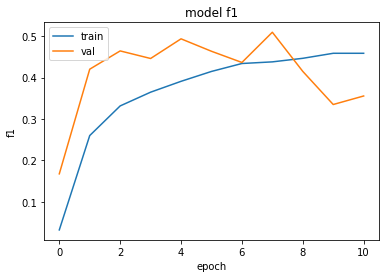

In [69]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['f1'])
plt.plot(model.history.history['val_f1'])
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [70]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=100)(inputs, )
convs = []

drop1 = tf.keras.layers.Dropout(0.2)(embeddings)

for ks in [2,3,4,5]:
    conv1 = tf.keras.layers.Conv1D(kernel_size=ks, filters=32, padding='same',strides=1)(drop1)
    conv2 = tf.keras.layers.Conv1D(kernel_size=ks, filters=32, padding='same',strides=1, 
                                  kernel_regularizer='l2', activation='relu')(conv1)
    convs.append(conv2)


concat = tf.keras.layers.concatenate(convs, axis=2)

conv_global = tf.keras.layers.Conv1D(kernel_size=5, filters=32, strides=1)(concat)
flatten = tf.keras.layers.Flatten()(conv_global)
dense = tf.keras.layers.Dense(50, activation='relu')(flatten)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(dense)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=[f1])

model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=4000,
         epochs=20,
         callbacks=[checkpoint, early_stop])

Epoch 1/20
310/311 [============================>.] - ETA: 0s - loss: 0.4278 - f1: 0.0092
Epoch 00001: val_f1 did not improve from 0.50953
311/311 [==============================] - 51s 164ms/step - loss: 0.4276 - f1: 0.0091 - val_loss: 0.1821 - val_f1: 0.0531
Epoch 2/20
310/311 [============================>.] - ETA: 0s - loss: 0.1753 - f1: 0.1829
Epoch 00002: val_f1 did not improve from 0.50953
311/311 [==============================] - 51s 163ms/step - loss: 0.1753 - f1: 0.1834 - val_loss: 0.1617 - val_f1: 0.2990
Epoch 3/20
310/311 [============================>.] - ETA: 0s - loss: 0.1624 - f1: 0.2983
Epoch 00003: val_f1 did not improve from 0.50953
311/311 [==============================] - 51s 165ms/step - loss: 0.1623 - f1: 0.2984 - val_loss: 0.1588 - val_f1: 0.4368
Epoch 4/20
310/311 [============================>.] - ETA: 0s - loss: 0.1560 - f1: 0.3430
Epoch 00004: val_f1 did not improve from 0.50953
311/311 [==============================] - 51s 164ms/step - loss: 0.1560 - f1:

dict_keys(['loss', 'f1', 'val_loss', 'val_f1'])


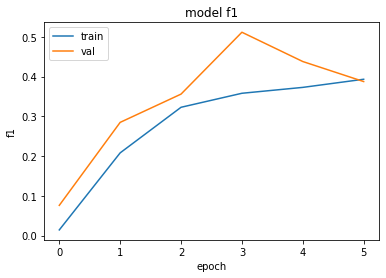

In [58]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['f1'])
plt.plot(model.history.history['val_f1'])
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [71]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=100)(inputs, )
convs = []

drop1 = tf.keras.layers.Dropout(0.2)(embeddings)

for ks in [2,3,4,5]:
    conv1 = tf.keras.layers.Conv1D(kernel_size=ks, filters=32, padding='same',strides=1)(drop1)
    conv2 = tf.keras.layers.Conv1D(kernel_size=ks, filters=32, padding='same',strides=1, 
                                  kernel_regularizer='l2', activation='relu')(conv1)
    convs.append(conv2)


concat = tf.keras.layers.concatenate(convs, axis=2)

drop2 = tf.keras.layers.Dropout(0.3)(concat)

conv_global = tf.keras.layers.Conv1D(kernel_size=5, filters=32, strides=1)(drop2)
flatten = tf.keras.layers.Flatten()(conv_global)
dense = tf.keras.layers.Dense(50, activation='relu')(flatten)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(dense)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=[f1])

model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=4000,
         epochs=20,
         callbacks=[checkpoint, early_stop])

Epoch 1/20
310/311 [============================>.] - ETA: 0s - loss: 0.4290 - f1: 0.0124
Epoch 00001: val_f1 did not improve from 0.50953
311/311 [==============================] - 54s 175ms/step - loss: 0.4289 - f1: 0.0129 - val_loss: 0.1885 - val_f1: 0.0249
Epoch 2/20
310/311 [============================>.] - ETA: 0s - loss: 0.1782 - f1: 0.1637
Epoch 00002: val_f1 did not improve from 0.50953
311/311 [==============================] - 54s 174ms/step - loss: 0.1782 - f1: 0.1634 - val_loss: 0.1703 - val_f1: 0.3391
Epoch 3/20
310/311 [============================>.] - ETA: 0s - loss: 0.1659 - f1: 0.2861
Epoch 00003: val_f1 did not improve from 0.50953
311/311 [==============================] - 54s 174ms/step - loss: 0.1659 - f1: 0.2862 - val_loss: 0.1625 - val_f1: 0.4299
Epoch 4/20
310/311 [============================>.] - ETA: 0s - loss: 0.1595 - f1: 0.3226
Epoch 00004: val_f1 did not improve from 0.50953
311/311 [==============================] - 54s 174ms/step - loss: 0.1595 - f1:

dict_keys(['loss', 'f1', 'val_loss', 'val_f1'])


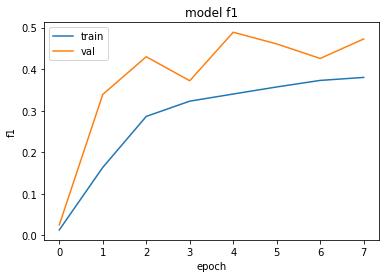

In [72]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['f1'])
plt.plot(model.history.history['val_f1'])
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [75]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=100)(inputs, )
convs = []

drop1 = tf.keras.layers.Dropout(0.2)(embeddings)

for ks in [2,3,4,5]:
    conv1 = tf.keras.layers.Conv1D(kernel_size=ks, filters=32, padding='same',strides=1)(drop1)
    conv2 = tf.keras.layers.Conv1D(kernel_size=ks, filters=32, padding='same',strides=1, 
                                  kernel_regularizer='l2', activation='relu')(conv1)
    convs.append(conv2)


concat = tf.keras.layers.concatenate(convs, axis=2)

pool = tf.keras.layers.AveragePooling1D()(concat)

drop2 = tf.keras.layers.Dropout(0.3)(pool)

conv_global = tf.keras.layers.Conv1D(kernel_size=5, filters=32, strides=1)(drop2)
flatten = tf.keras.layers.Flatten()(conv_global)
dense = tf.keras.layers.Dense(50, activation='relu')(flatten)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(dense)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=[f1])

model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=4000,
         epochs=20,
         callbacks=[checkpoint, early_stop])

Epoch 1/20
311/311 [==============================] - ETA: 0s - loss: 0.4367 - f1: 0.0016
Epoch 00001: val_f1 did not improve from 0.50953
311/311 [==============================] - 53s 172ms/step - loss: 0.4367 - f1: 0.0016 - val_loss: 0.1999 - val_f1: 0.0058
Epoch 2/20
310/311 [============================>.] - ETA: 0s - loss: 0.1843 - f1: 0.0861
Epoch 00002: val_f1 did not improve from 0.50953
311/311 [==============================] - 53s 170ms/step - loss: 0.1843 - f1: 0.0864 - val_loss: 0.1694 - val_f1: 0.2384
Epoch 3/20
310/311 [============================>.] - ETA: 0s - loss: 0.1699 - f1: 0.2335
Epoch 00003: val_f1 did not improve from 0.50953
311/311 [==============================] - 53s 171ms/step - loss: 0.1699 - f1: 0.2335 - val_loss: 0.1707 - val_f1: 0.3935
Epoch 4/20
310/311 [============================>.] - ETA: 0s - loss: 0.1643 - f1: 0.2818
Epoch 00004: val_f1 did not improve from 0.50953
311/311 [==============================] - 53s 170ms/step - loss: 0.1643 - f1:

dict_keys(['loss', 'f1', 'val_loss', 'val_f1'])


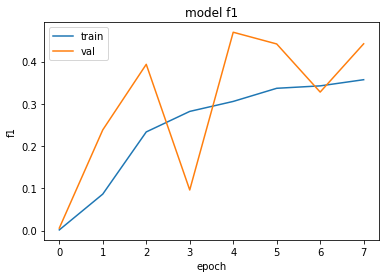

In [76]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['f1'])
plt.plot(model.history.history['val_f1'])
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [77]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=100)(inputs, )
convs = []
convs2 = []

drop1 = tf.keras.layers.Dropout(0.2)(embeddings)

for ks in [2,3,4,5]:
    conv1 = tf.keras.layers.Conv1D(kernel_size=ks, filters=32, padding='same',strides=1)(drop1)
    conv2 = tf.keras.layers.Conv1D(kernel_size=ks, filters=32, padding='same',strides=1, 
                                  kernel_regularizer='l2', activation='relu')(conv1)
    convs.append(conv2)


concat = tf.keras.layers.concatenate(convs, axis=2)

pool = tf.keras.layers.AveragePooling1D()(concat)

drop2 = tf.keras.layers.Dropout(0.3)(pool)

for ks in [2,3,4,5]:
    conv1 = tf.keras.layers.Conv1D(kernel_size=ks, filters=16, padding='same',strides=1)(drop1)
    conv2 = tf.keras.layers.Conv1D(kernel_size=ks, filters=16, padding='same',strides=1, 
                                  kernel_regularizer='l2', activation='relu')(conv1)
    convs2.append(conv2)


concat2 = tf.keras.layers.concatenate(convs2, axis=2)

flatten = tf.keras.layers.Flatten()(concat2)
dense = tf.keras.layers.Dense(50, activation='relu')(flatten)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(dense)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=[f1])

model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=4000,
         epochs=20,
         callbacks=[checkpoint, early_stop])

Epoch 1/20
311/311 [==============================] - ETA: 0s - loss: 0.3710 - f1: 2.7386e-04
Epoch 00001: val_f1 did not improve from 0.50953
311/311 [==============================] - 46s 147ms/step - loss: 0.3710 - f1: 2.7386e-04 - val_loss: 0.1933 - val_f1: 0.0000e+00
Epoch 2/20
310/311 [============================>.] - ETA: 0s - loss: 0.1815 - f1: 0.0708
Epoch 00002: val_f1 did not improve from 0.50953
311/311 [==============================] - 45s 143ms/step - loss: 0.1815 - f1: 0.0708 - val_loss: 0.1738 - val_f1: 0.1473
Epoch 3/20
310/311 [============================>.] - ETA: 0s - loss: 0.1727 - f1: 0.1463
Epoch 00003: val_f1 did not improve from 0.50953
311/311 [==============================] - 45s 144ms/step - loss: 0.1727 - f1: 0.1465 - val_loss: 0.1687 - val_f1: 0.1442
Epoch 4/20
310/311 [============================>.] - ETA: 0s - loss: 0.1673 - f1: 0.2073
Epoch 00004: val_f1 did not improve from 0.50953
311/311 [==============================] - 45s 143ms/step - loss: 

dict_keys(['loss', 'f1', 'val_loss', 'val_f1'])


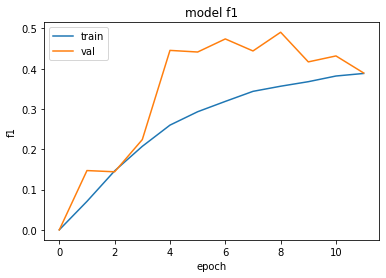

In [78]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['f1'])
plt.plot(model.history.history['val_f1'])
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [89]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=100)(inputs, )
convs = []
convs2 = []

drop1 = tf.keras.layers.Dropout(0.2)(embeddings)

for ks in [2,3,4,5]:
    conv1 = tf.keras.layers.Conv1D(kernel_size=ks, filters=32, padding='same',strides=1)(drop1)
    conv2 = tf.keras.layers.Conv1D(kernel_size=ks, filters=32, padding='same',strides=1, 
                                  kernel_regularizer='l2', activation='relu')(conv1)
    convs.append(conv2)


concat = tf.keras.layers.concatenate(convs, axis=2)

pool = tf.keras.layers.AveragePooling1D()(concat)

for ks in [2,3,4,5]:
    conv1 = tf.keras.layers.Conv1D(kernel_size=ks, filters=48, padding='same',strides=1)(pool)
    conv2 = tf.keras.layers.Conv1D(kernel_size=ks, filters=48, padding='same',strides=1, 
                                  kernel_regularizer='l2', activation='relu')(conv1)
    convs2.append(conv2)


concat2 = tf.keras.layers.concatenate(convs2, axis=2)

pool2 = tf.keras.layers.AveragePooling1D()(concat2)

drop3 = tf.keras.layers.Dropout(0.4)(pool2)

conv_global = tf.keras.layers.Conv1D(kernel_size=5, filters=32, strides=10)(drop3)

flatten = tf.keras.layers.Flatten()(conv_global)
dense = tf.keras.layers.Dense(50, activation='relu')(flatten)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(dense)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=[f1])

model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=4000,
         epochs=20,
         callbacks=[checkpoint, early_stop])

Epoch 1/20
311/311 [==============================] - ETA: 0s - loss: 0.7123 - f1: 3.9711e-04
Epoch 00001: val_f1 did not improve from 0.50953
311/311 [==============================] - 76s 244ms/step - loss: 0.7123 - f1: 3.9711e-04 - val_loss: 0.2097 - val_f1: 0.0000e+00
Epoch 2/20
311/311 [==============================] - ETA: 0s - loss: 0.2014 - f1: 0.0086
Epoch 00002: val_f1 did not improve from 0.50953
311/311 [==============================] - 73s 236ms/step - loss: 0.2014 - f1: 0.0086 - val_loss: 0.1907 - val_f1: 0.0530
Epoch 3/20
311/311 [==============================] - ETA: 0s - loss: 0.1858 - f1: 0.0995
Epoch 00003: val_f1 did not improve from 0.50953
311/311 [==============================] - 74s 236ms/step - loss: 0.1858 - f1: 0.0995 - val_loss: 0.1767 - val_f1: 0.1719
Epoch 4/20
311/311 [==============================] - ETA: 0s - loss: 0.1780 - f1: 0.1813
Epoch 00004: val_f1 did not improve from 0.50953
311/311 [==============================] - 73s 235ms/step - loss: 

dict_keys(['loss', 'f1', 'val_loss', 'val_f1'])


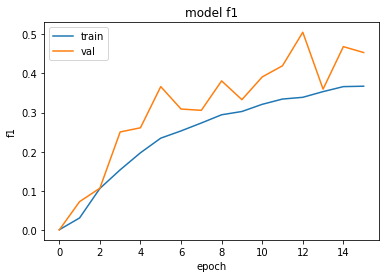

In [135]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['f1'])
plt.plot(model.history.history['val_f1'])
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## preprocessing

In [0]:
def char_preprocess_2(text):
    tokens = list(text.strip(punctuation))
    tokens = [token for token in tokens if token.lower().isalnum() == True or token == " "]
    return tokens

In [0]:
vocab = Counter()

for text in quora.question_text:
    vocab.update(char_preprocess_2(text))

# отфильтрованный словарь
filtered_vocab = set()

for word in vocab:
    if vocab[word] > 5:
        filtered_vocab.add(word)

word2id = {'UNK':1, 'PAD':0}

for word in filtered_vocab:
    word2id[word] = len(word2id)

id2word = {i:word for word, i in word2id.items()}

X = []

for text in quora.question_text:
    tokens = char_preprocess_2(text)
    ids = [word2id.get(token, 1) for token in tokens]
    X.append(ids)

In [138]:
for i in range(10,1000,50):
  print(i, len([len(x) for x in X if len(x) <= i]))

10 163
60 685663
110 1144237
160 1263266
210 1292011
260 1306095
310 1306117
360 1306119
410 1306119
460 1306119
510 1306120
560 1306120
610 1306121
660 1306121
710 1306122
760 1306122
810 1306122
860 1306122
910 1306122
960 1306122


In [0]:
MAX_LEN = 110 # при этом значении мы покрывем немнгим меньше чем 90% текстов

X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=MAX_LEN)

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.05, stratify=y)

In [140]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=100)(inputs, )
convs = []
convs2 = []

drop1 = tf.keras.layers.Dropout(0.2)(embeddings)

for ks in [2,3,4,5]:
    conv1 = tf.keras.layers.Conv1D(kernel_size=ks, filters=32, padding='same',strides=1)(drop1)
    conv2 = tf.keras.layers.Conv1D(kernel_size=ks, filters=32, padding='same',strides=1, 
                                  kernel_regularizer='l2', activation='relu')(conv1)
    convs.append(conv2)


concat = tf.keras.layers.concatenate(convs, axis=2)

pool = tf.keras.layers.AveragePooling1D()(concat)

for ks in [2,3,4,5]:
    conv1 = tf.keras.layers.Conv1D(kernel_size=ks, filters=48, padding='same',strides=1)(pool)
    conv2 = tf.keras.layers.Conv1D(kernel_size=ks, filters=48, padding='same',strides=1, 
                                  kernel_regularizer='l2', activation='relu')(conv1)
    convs2.append(conv2)


concat2 = tf.keras.layers.concatenate(convs2, axis=2)

pool2 = tf.keras.layers.AveragePooling1D()(concat2)

drop3 = tf.keras.layers.Dropout(0.4)(pool2)

conv_global = tf.keras.layers.Conv1D(kernel_size=5, filters=32, strides=10)(drop3)

flatten = tf.keras.layers.Flatten()(conv_global)
dense = tf.keras.layers.Dense(50, activation='relu')(flatten)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(dense)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=[f1])

model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=4000,
         epochs=20,
         callbacks=[checkpoint, early_stop])

Epoch 1/20
311/311 [==============================] - ETA: 0s - loss: 0.6999 - f1: 3.9808e-04
Epoch 00001: val_f1 did not improve from 0.50953
311/311 [==============================] - 74s 238ms/step - loss: 0.6999 - f1: 3.9808e-04 - val_loss: 0.2123 - val_f1: 0.0000e+00
Epoch 2/20
311/311 [==============================] - ETA: 0s - loss: 0.2012 - f1: 0.0149
Epoch 00002: val_f1 did not improve from 0.50953
311/311 [==============================] - 74s 237ms/step - loss: 0.2012 - f1: 0.0149 - val_loss: 0.1903 - val_f1: 0.0434
Epoch 3/20
311/311 [==============================] - ETA: 0s - loss: 0.1892 - f1: 0.0751
Epoch 00003: val_f1 did not improve from 0.50953
311/311 [==============================] - 74s 237ms/step - loss: 0.1892 - f1: 0.0751 - val_loss: 0.1861 - val_f1: 0.0645
Epoch 4/20
311/311 [==============================] - ETA: 0s - loss: 0.1821 - f1: 0.1447
Epoch 00004: val_f1 did not improve from 0.50953
311/311 [==============================] - 74s 237ms/step - loss: 

dict_keys(['loss', 'f1', 'val_loss', 'val_f1'])


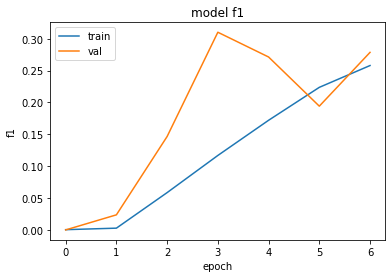

In [129]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['f1'])
plt.plot(model.history.history['val_f1'])
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [0]:
def char_preprocess_3(text):
    tokens = list(text.strip(punctuation))
    tokens = [token for token in tokens if token.lower().isalnum() == True or token == " "]
    new_tokens = []
    for token in tokens:
      if token.isnumeric():
        new_tokens.append("NUM")
      else:
        new_tokens.append(token)
    res = []
    for i in range(1,len(new_tokens)):
      if new_tokens[i-1] == "NUM" and new_tokens[i] == "NUM":
        continue
      else:
        res.append(new_tokens[i-1])
      if i == len(new_tokens) - 1:
        res.append(new_tokens[i])
    return res

In [0]:
vocab = Counter()

for text in quora.question_text:
    vocab.update(char_preprocess_3(text))

# отфильтрованный словарь
filtered_vocab = set()

for word in vocab:
    if vocab[word] > 5:
        filtered_vocab.add(word)

word2id = {'UNK':1, 'PAD':0}

for word in filtered_vocab:
    word2id[word] = len(word2id)

id2word = {i:word for word, i in word2id.items()}

X = []

for text in quora.question_text:
    tokens = char_preprocess_3(text)
    ids = [word2id.get(token, 1) for token in tokens]
    X.append(ids)

In [154]:
for i in range(10,1000,50):
  print(i, len([len(x) for x in X if len(x) <= i]))

10 330
60 689286
110 1145454
160 1263629
210 1292208
260 1306097
310 1306118
360 1306119
410 1306119
460 1306119
510 1306120
560 1306120
610 1306121
660 1306121
710 1306122
760 1306122
810 1306122
860 1306122
910 1306122
960 1306122


In [0]:
MAX_LEN = 110 # при этом значении мы покрывем немнгим меньше чем 90% текстов

X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=MAX_LEN)

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.05, stratify=y)

In [159]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=100)(inputs, )
convs = []
convs2 = []

drop1 = tf.keras.layers.Dropout(0.2)(embeddings)

for ks in [2,3,4,5]:
    conv1 = tf.keras.layers.Conv1D(kernel_size=ks, filters=32, padding='same',strides=1)(drop1)
    conv2 = tf.keras.layers.Conv1D(kernel_size=ks, filters=32, padding='same',strides=1, 
                                  kernel_regularizer='l2', activation='relu')(conv1)
    convs.append(conv2)


concat = tf.keras.layers.concatenate(convs, axis=2)

pool = tf.keras.layers.AveragePooling1D()(concat)

for ks in [2,3,4,5]:
    conv1 = tf.keras.layers.Conv1D(kernel_size=ks, filters=48, padding='same',strides=1)(pool)
    conv2 = tf.keras.layers.Conv1D(kernel_size=ks, filters=48, padding='same',strides=1, 
                                  kernel_regularizer='l2', activation='relu')(conv1)
    convs2.append(conv2)


concat2 = tf.keras.layers.concatenate(convs2, axis=2)

pool2 = tf.keras.layers.AveragePooling1D()(concat2)

drop3 = tf.keras.layers.Dropout(0.4)(pool2)

conv_global = tf.keras.layers.Conv1D(kernel_size=5, filters=32, strides=10)(drop3)

flatten = tf.keras.layers.Flatten()(conv_global)
dense = tf.keras.layers.Dense(50, activation='relu')(flatten)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(dense)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=[f1])

model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=4000,
         epochs=20,
         callbacks=[checkpoint, early_stop])

Epoch 1/20
311/311 [==============================] - ETA: 0s - loss: 0.6990 - f1: 4.2170e-04
Epoch 00001: val_f1 improved from -inf to 0.00000, saving model to model.weights
311/311 [==============================] - 73s 235ms/step - loss: 0.6990 - f1: 4.2170e-04 - val_loss: 0.2102 - val_f1: 0.0000e+00
Epoch 2/20
311/311 [==============================] - ETA: 0s - loss: 0.1994 - f1: 0.0120
Epoch 00002: val_f1 improved from 0.00000 to 0.03644, saving model to model.weights
311/311 [==============================] - 73s 234ms/step - loss: 0.1994 - f1: 0.0120 - val_loss: 0.1872 - val_f1: 0.0364
Epoch 3/20
311/311 [==============================] - ETA: 0s - loss: 0.1862 - f1: 0.0921
Epoch 00003: val_f1 improved from 0.03644 to 0.06647, saving model to model.weights
311/311 [==============================] - 73s 234ms/step - loss: 0.1862 - f1: 0.0921 - val_loss: 0.1887 - val_f1: 0.0665
Epoch 4/20
311/311 [==============================] - ETA: 0s - loss: 0.1812 - f1: 0.1513
Epoch 00004: 

dict_keys(['loss', 'f1', 'val_loss', 'val_f1'])


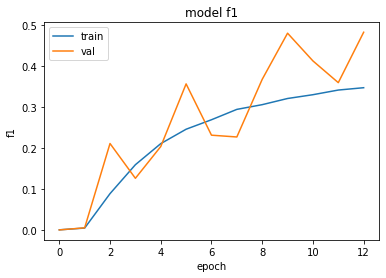

In [157]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['f1'])
plt.plot(model.history.history['val_f1'])
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Немного покрутив нормализацию, выяснилось, что она не особо влияет на резульатты работы модели